Imports for topic modelling

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords') # only download once
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
import time
warnings.simplefilter("ignore", DeprecationWarning)
import spacy
import de_core_news_lg
nlp = de_core_news_lg.load(disable=['parser'])
import datetime
from gensim import corpora,models
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus
from gensim.models import LdaSeqModel
from gensim.test.utils import datapath
from importlib import reload
import logging
import re
logging.basicConfig(filename='gensim5.log',filemode='w',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)
reload(logging)
from gensim.models import CoherenceModel
warnings.filterwarnings("ignore",category=DeprecationWarning)
import tqdm
import gensim
# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()
pd.options.display.max_rows = 50
pd.options.display.min_rows = 15

my_path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/"
print('done')

done


Build dataframes from text data, 
each text-file contains one tagesschau transcription.

In [3]:
# load the s2t transcriptions
def load_transcriptions(path):
    os.chdir(path)
    transcriptions = os.listdir()#[:30]
    return transcriptions

# Preprocessing for topic modelling, in this case LDA
# use SpaCy Pipe for faster lemmatizing
def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=int(len(texts)/n_cpu_cores),n_process=int(n_cpu_cores)):
        preproc_pipe.append([str(word.lemma_).lower() for word in doc if not word.is_stop and word.is_alpha])
    return preproc_pipe


# preprocess transcriptions: remove: "newline", punctuations, stopwords (automatically and manually chosen ones
# create bi-/tri-grams and add meta-data date.
def preprocess_transcriptions(transcripts_df,number_cpu_cores=os.cpu_count()-1):
    

    # save transcriptions of tagesschau in DataFrame
    df = pd.DataFrame(index=[i for i in range(len(transcriptions)) if "tagesschau" in transcriptions[i]], columns=['transcriptionName','content','preprocessed','year','month','day'])
    for transcription in range(len(transcriptions)):
        if "tagesschau" in str(transcriptions[transcription]) and 'vor' not in str(transcriptions[transcription]):
            with open(transcriptions[transcription], "r") as f:
                df.at[transcription,'transcriptionName'] = str(transcriptions[transcription])
                df.at[transcription,'content'] = f.read()
    df = df.reset_index()
    
    # remove "newline" and punctuation
    for transcript in range(len(df)):
        df.at[transcript,'preprocessed'] = df.loc[transcript,'content'].replace("\n","").replace(".","")
    start_timer_preprocess = datetime.datetime.now()
    df['preprocessed'] = preprocess_pipe(df['preprocessed'])
    
    print("lemmatizing needs:",round((datetime.datetime.now()-start_timer_preprocess).total_seconds(),2),"seconds")

    # Create substitutions for a better overview and easier usage/changing of manual stopwords.
    # Furthermore, useable for correcting of text2speech (korona->corona)
    manual = [[['wetter'],['sonne','regen','wind','schnee','schauer','luft','wolken','gewitter','gewittern']],
              [['himmelsrichtung'],['norden','sueden','osten','westen']],
              [['wochentag'],['montag','dienstag','mittwoch','donnerstag','freitag','samstag','sonntag']],
              [['monat'],['januar','februar','maerz','april','mai','juni','juli','august','september','oktober','november','dezember']],
              [['corona'],['korona']]]
    
    start_manual = datetime.datetime.now()
    
    # Apply above manual substitutions
    for i in range(len(df)):
        for k in manual:
                for l in range(len(k[1])):
                    df.at[i,'preprocessed'] = [k[0][0] if k[1][l]==x else x for x in df.loc[i,'preprocessed']]
    
    print("replacing e.g. 'sonne','regen'... by 'wetter' needs:",
          round((datetime.datetime.now()-start_manual).total_seconds(),2),"seconds")    
    
    # As we use automatic stopword removal (+ filter_extreme method later), we only remove weather, cardinal direction, 
    # weekday and month
    manual_stopwords = ['wetter','wochentag','monat','himmelsrichtung']
    
    # Remove manual chosen stopwords.
    for i in range(len(df)):
        df.at[i,'preprocessed'] = [word for word in df.loc[i,'preprocessed'] if word not in manual_stopwords]
        
    # Create bi-/tri-grams for words which occur together multiple times.
    start_bi_trigram = datetime.datetime.now()
    list_of_all_for_bigram = []
    for i in range(len(df)):
        list_of_all_for_bigram.append(df.loc[i,'preprocessed'])
    bigram = models.Phrases(list_of_all_for_bigram, min_count=20, threshold=50)
    trigram = models.Phrases(bigram[list_of_all_for_bigram], threshold=50)
    bigram_mod = models.phrases.Phraser(bigram)
    trigram_mod = models.phrases.Phraser(trigram)
    for i in range(len(df)):
        df.at[i,'preprocessed'] = bigram_mod[df.loc[i,'preprocessed']]
        df.at[i,'preprocessed'] = trigram_mod[bigram_mod[df.loc[i,'preprocessed']]]
    for i in range(len(df)):
        df.at[i,'preprocessed'] = (','.join(df.loc[i,'preprocessed'])).replace(','," ")
    
    print("Bi-/Tri-Grams needs:",round((datetime.datetime.now()-start_bi_trigram).total_seconds(),2),"seconds")
    
    
    # save metadata of transcriptions in DataFrame
    for i in range(len(df)):
        if 'tagesschau' in df.loc[i,'transcriptionName'] and 'vor' not in df.loc[i,'transcriptionName']:
            df.at[i,'year'] = int((df.loc[i,'transcriptionName'].split('_')[1][4:8]))
            df.at[i,'month'] = int((df.loc[i,'transcriptionName'].split('_')[1][2:4]))
            df.at[i,'day'] = int((df.loc[i,'transcriptionName'].split('_')[1][0:2]))
    
    return df

Preprocess data for given daterange in yearly portions for feasibility in terms of RAM usage.

In [79]:
%%time
# set Path
my_path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/"
n_cpu_cores = int(os.cpu_count()/2-1)
print("number cpu_cores to use:",n_cpu_cores)
df_all_processed = pd.DataFrame(index=[], columns=['preprocessed'])


#load speech2text transcriptions
path = my_path+"transcripts/"
transcriptions = load_transcriptions(path)
keys = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
years_dict = {}
for year in keys: 
    years_dict[year] = []

# prepare daterange of interest for lda
daterange = pd.date_range(datetime.datetime(2006, 12, 19), datetime.datetime(2021, 11, 11))
dates_of_interest = []
for date in daterange:
    for i in transcriptions:
        if 'tagesschau' in i and 'vor' not in i:
            year = int((i.split('_')[1][4:8]))
            if year==date.year:
                month = int((i.split('_')[1][2:4]))
                if month == date.month:
                    day = int((i.split('_')[1][0:2]))
                    if day == date.day:
                        years_dict[str(year)].append(i)
                        dates_of_interest.append(i)
print("There are ",len(dates_of_interest),"transcriptions in given daterange")

yearsLen = []
# preprocess every year
for year in years_dict.keys():
    print("\npreprocess transcriptions of year:",year,", quantity:",len(years_dict[str(year)]))
    if len(years_dict[str(year)]) > 0:
        yearsLen.append(len(years_dict[str(year)]))
    if len(years_dict[str(year)]) == 0:
        print("no transcription for year:",year)
        continue
    start = datetime.datetime.now()
    transcriptions = years_dict[str(year)]
    df_processed = preprocess_transcriptions(transcriptions,number_cpu_cores=n_cpu_cores)
    df_all_processed = pd.concat([df_all_processed,df_processed],ignore_index=True)
    

display(df_all_processed)
          
print("length of DataFrame:",len(df_all_processed))

print("number of transcriptions of each year in chosen daterange:",yearsLen)

# save lda
df_all_processed.to_csv(my_path+"ldas/df.csv",sep=',',index=False)

print("\ndone")

number cpu_cores to use: 7
There are  4926 transcriptions in given daterange

preprocess transcriptions of year: 2007 , quantity: 263
lemmatizing needs: 22.35 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.49 seconds
Bi-/Tri-Grams needs: 5.03 seconds

preprocess transcriptions of year: 2008 , quantity: 357
lemmatizing needs: 31.41 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.67 seconds
Bi-/Tri-Grams needs: 6.06 seconds

preprocess transcriptions of year: 2009 , quantity: 357
lemmatizing needs: 31.01 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.67 seconds
Bi-/Tri-Grams needs: 6.06 seconds

preprocess transcriptions of year: 2010 , quantity: 357
lemmatizing needs: 29.75 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.65 seconds
Bi-/Tri-Grams needs: 5.88 seconds

preprocess transcriptions of year: 2011 , quantity: 353
lemmatizing needs: 29.95 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.67 seconds
Bi-/Tri

,preprocessed,index,transcriptionName,content,year,month,day
0,deutsch_fernsehen_tagesschau_gut abend_dame_he...,0.0,tagesschau_01042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,1
1,deutsch_fernsehen_tagesschau abend_dame_herr j...,1.0,tagesschau_02042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,2
2,deutsch_fernsehen_tagesschau_gut abend_dame_he...,2.0,tagesschau_03042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,3
3,deutsch_fernsehen_tagesschau_gut abend_dame_he...,3.0,tagesschau_04042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,4
4,deutsch_fernsehen_tagesschau dame_herr iran fe...,4.0,tagesschau_05042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,5
5,deutsch_fernsehen_tagesschau_gut abend_dame_he...,5.0,tagesschau_06042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,6
6,deutsch_fernsehen_tagesschau_gut abend_dame_he...,6.0,tagesschau_07042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,7
...,...,...,...,...,...,...,...
4919,deutsch_fernsehen_tagesschau_studio jens_riewa...,325.0,tagesschau_23112020_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2020,11,23
4920,deutsch_fernsehen_tagesschau_studio thorsten_s...,326.0,tagesschau_24112020_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2020,11,24


len of df: 4926
number of transcriptions of each year in chosen daterange: [263, 357, 357, 357, 353, 357, 362, 365, 365, 367, 365, 364, 362, 332]

done
CPU times: user 3min 56s, sys: 20.5 s, total: 4min 17s
Wall time: 9min 1s


Initialize array and dictionary to save all computed models while searching for best number of topics.

In [4]:
lda_models = []
model_coherences = {'Topics': [], 'Coherence': [], 'no_below': [], 'no_above': []}

Function to train lda and compute its coherence score

In [5]:
def train_lda_compute_coherence(corpus, texts, dictionary, n_topics, workers, no_below=20, no_above=0.5):
    global lda_models
    passes = 500
    iterations = 500
    # train LDA
    # workers: recommended is using number of pyhsical CPU cores - 1
    # for us, less cores worked better
    # minimum_probability=0 for proper usage in topic modeling over time, as you keep all probabilities.
    # chunksize with best performance when using #transcripts/workers (chunksize=transcripts, if there is enough RAM)
    # at least 500 passes and iterations to have high probability of convergence, as we have less data (~5000 transcriptions)
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics,
                                           random_state=10,
                                           chunksize=int(len(df['preprocessed'])/workers),
                                           passes=passes, 
                                           iterations=iterations,
                                           per_word_topics=True,
                                           eval_every=50, # useable for logging 
                                           workers=workers,
                                           minimum_probability=0)
                                           #callbacks=[coherence_logger]) # not supported for multicore-method
    
    
    Path(my_path+"lda/lda_"+str(n_topics)+"topics_"+str(passes)+"passes_"+str(iterations)+"iter"+str(no_below)+"no_below"+str(no_above)+"no_above").mkdir(parents=True, exist_ok=True)
    lda_model.save(my_path+"lda/lda_"+str(n_topics)+"topics_"+str(passes)+"passes_"+str(iterations)+"iter"+str(no_below)+"no_below"+str(no_above)+"no_above"+"/lda")
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed'], dictionary=id2word, coherence='c_v')
    #lda_models.append([n_topics,lda_model,coherence_model_lda])
    return coherence_model_lda.get_coherence()

Train LDAs and obtain their coherence value with different number of topics.

In [8]:
%%time
# set Path
my_path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/"
# load transcriptions and prepare them for LDA
df_all_processed = pd.read_csv(my_path+'ldas/df1.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df = df_all_processed.copy()
print("number of transcriptions:",len(df))
for i in range(len(df['preprocessed'])):
        df.at[i,'preprocessed'] = df.loc[i,'preprocessed'].split(" ")

# train for different topics and different filtering of dictionary

no_below = 20
no_above = 0.5

id2word = corpora.Dictionary(df['preprocessed'])
print("number words in dictionary before filtering:",len(id2word))
# filter dictionary for high and low frequency words
id2word.filter_extremes(no_below = 20, no_above=0.5)
print("number words in dictionary after filtering:",len(id2word))
corpus = [id2word.doc2bow(doc) for doc in df['preprocessed']]

# set topic range
min_topics = 50
max_topics = 60
step_size = 10
topics_range = range(min_topics, max_topics, step_size)


n_iterations = (len(topics_range))
print("number of iterations:", n_iterations)

# init tqdm bar for better looking logging
pbar = tqdm.tqdm(total=n_iterations)

# compute coherences for topic numbers in given range
for n_topics in topics_range:
    print("no_below: "+str(no_below)+" no_above: "+str(no_above)+" n_topics:",n_topics)

    # get the coherence score for the given parameters
    cs = train_lda_compute_coherence(corpus=corpus,texts=df['preprocessed'], dictionary=id2word, 
                                  n_topics=n_topics, workers=2, no_below=no_below, no_above=no_above)
    print("coherence score is:",cs)
    # Save coherence-values
    model_coherences['Topics'].append(n_topics)
    model_coherences['Coherence'].append(cs)
    model_coherences['no_below'].append(no_below)
    model_coherences['no_above'].append(no_above)
    pbar.update(1)
pbar.close()
df_model_coherences = pd.DataFrame(model_coherences)
df_model_coherences.to_csv(my_path+'ldas/df_model_coherence', index=False)
print("done")


number of transcriptions: 4925
number words in dictionary before filtering: 158756
number words in dictionary after filtering: 17526


  0%|          | 0/1 [00:00<?, ?it/s]

number of iterations: 1
no_below: 20 no_above: 0.5 n_topics: 50


100%|██████████| 1/1 [00:23<00:00, 23.82s/it]

coherence score is: 0.2280066563739936
done
CPU times: user 16.2 s, sys: 6.59 s, total: 22.8 s
Wall time: 31 s


For topic modeling over time, recreate dictionary and corpus from preprocessed data for given model.

In [84]:
df_all_processed = pd.read_csv(my_path+'ldas/df1.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df = df_all_processed.copy()
print("number of transcriptions:",len(df))
for i in range(len(df['preprocessed'])):
        df.at[i,'preprocessed'] = df.loc[i,'preprocessed'].split(" ")
id2word = corpora.Dictionary(df['preprocessed'])
print("number words in dictionary before filtering:",len(id2word))
id2word.filter_extremes(no_below = 20, no_above=0.5)
print("number words in dictionary after filtering:",len(id2word))
corpus = [id2word.doc2bow(doc) for doc in df['preprocessed']]

number of transcriptions: 4925
number words in dictionary before filtering: 158756
number words in dictionary after filtering: 17526


Load a lda model and show its topics and coherence_value.

In [14]:
lda_model = gensim.models.LdaModel.load(my_path+"lda/bestmodelcv/model/lda_26topics_500passes_500iter_0.5filterValue.model")
#lda_model = gensim.models.LdaModel.load(my_path+"lda/lda_40topics_500passes_500iter20no_below0.5no_above/lda")
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed'], dictionary=id2word, coherence='c_v')
print(coherence_model_lda.get_coherence())

print(lda_model)
print("\n------------------------------------------------\n")
for topic_number,topic in lda_model.print_topics(-1):
        probs = ((topic.replace('"','').replace(" ","").split('+')))
        for prob in range(len(probs)):
            probs[prob] = (probs[prob].split("*"))
        probs_formatted = [str(x[1])+'('+str(x[0])+')' for x in probs]
        print('Topic: {} \nWords: {}'.format(topic_number+1,probs_formatted))

0.6067830534796081
LdaModel(num_terms=17526, num_topics=26, decay=0.5, chunksize=265)

------------------------------------------------

Topic: 1 
Words: ['energiewende(0.058)', 'energie(0.035)', 'kohle(0.034)', 'strom(0.033)', 'kraftwerk(0.031)', 'erneuerbaren_energie(0.020)', 'ausbau(0.020)', 'atomausstieg(0.017)', 'ökostrom(0.014)', 'kohlekraftwerke(0.011)']
Topic: 2 
Words: ['trump(0.011)', 'china(0.006)', 'deutsch_fernsehen_tagesschau_studio(0.004)', 'afd(0.004)', 'protest(0.003)', 'us-amerikanischen(0.003)', 'washington(0.003)', 'gipfel(0.003)', 'donald_trump(0.003)', 'gespräch(0.003)']
Topic: 3 
Words: ['haus(0.008)', 'wasser(0.007)', 'region(0.005)', 'lage(0.004)', 'hilfe(0.004)', 'behörde(0.004)', 'straße(0.004)', 'zerstören(0.003)', 'inzwischen(0.003)', 'katastrophe(0.003)']
Topic: 4 
Words: ['israel(0.015)', 'anschlag(0.009)', 'palästinenser(0.006)', 'soldat(0.006)', 'ägypten(0.005)', 'töten(0.005)', 'opfer(0.005)', 'polizei(0.005)', 'verletzen(0.004)', 'afghanistan(0.004)']

Show intertopic distances to get an overview of topic distribution.

In [15]:
display(pyLDAvis.gensim.prepare(lda_model, corpus, id2word))

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22    -0.058082 -0.042765       1        1  12.170171
20    -0.055501  0.059246       2        1  10.290123
25    -0.075135  0.030793       3        1   7.616765
5     -0.094149  0.032853       4        1   7.043959
15    -0.038565 -0.065183       5        1   6.693245
3     -0.013821 -0.199681       6        1   5.738242
2     -0.026409 -0.154057       7        1   5.658954
1     -0.075514 -0.022460       8        1   5.347517
4     -0.059507  0.043897       9        1   4.584429
13    -0.039259 -0.069360      10        1   4.544985
21     0.020821 -0.156767      11        1   4.273070
10    -0.061389  0.078192      12        1   4.214615
14    -0.038637  0.028568      13        1   3.834583
17    -0.053022 -0.045425      14        1   3.478549
12    -0.081026 -0.001294      15        1   3.358021
7     -0.099942  0.007970      16        1   2.327830
24     0.029846 -0.176617      17        1   1.735789
11    -0.011452  0.088393      18        1   1.700196
18    -0.019247  0.033609      19        1   1.336739
23     0.086546  0.049666      20        1   1.039486
6     -0.020416  0.207489      21        1   1.018397
19    -0.045170  0.194678      22        1   1.016539
9      0.276185  0.061206      23        1   0.310270
16     0.272433 -0.011669      24        1   0.267155
8      0.121926  0.002768      25        1   0.205915
0      0.158486  0.025949      26        1   0.194459, topic_info=               Term         Freq        Total Category  logprob  loglift
3902     flüchtling  4764.000000  4764.000000  Default  30.0000  30.0000
8478   griechenland  2915.000000  2915.000000  Default  29.0000  29.0000
772             spd  6389.000000  6389.000000  Default  28.0000  28.0000
175            iran  1989.000000  1989.000000  Default  27.0000  27.0000
1140       russland  5034.000000  5034.000000  Default  26.0000  26.0000
804          türkei  3930.000000  3930.000000  Default  25.0000  25.0000
3991         syrien  3082.000000  3082.000000  Default  24.0000  24.0000
...             ...          ...          ...      ...      ...      ...
2556      industrie    43.815628   790.024902  Topic26  -4.9424   3.3506
2228        ausstoß    27.102098   213.397690  Topic26  -5.4228   4.1792
190     klimaschutz    38.951187   935.346313  Topic26  -5.0601   3.0641
2303          grüne    43.346554  3724.342285  Topic26  -4.9532   1.7893
8197  beschleunigen    25.014545   243.496155  Topic26  -5.5029   3.9671
1424     kanzleramt    29.339153   849.183716  Topic26  -5.3435   2.8774
2288        gabriel    27.805990   723.534668  Topic26  -5.3972   2.9838

[1790 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
7048       6  0.988587                abbas
17328      1  0.973647  abgasmanipulationen
15374      3  0.040985            abgasnorm
15374     18  0.901675            abgasnorm
17074     14  0.053909         abgasskandal
17074     18  0.929925         abgasskandal
3128       1  0.226174          abgeordnete
...      ...       ...                  ...
870        5  0.008351       überschwemmung
870        7  0.901882       überschwemmung
870       15  0.013918       überschwemmung
870       19  0.072373       überschwemmung
5353       1  0.478603          überstimmen
5353      14  0.143581          überstimmen
5353      23  0.382882          überstimmen

[8655 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 21, 26, 6, 16, 4, 3, 2, 5, 14, 22, 11, 15, 18, 13, 8, 25, 12, 19, 24, 7, 20, 10, 17, 9, 1])

For modelling the topics over time, we followed and modified instructions by
https://medium.com/the-die-is-forecast/topic-modeling-as-osint-exploring-russian-presidential-speech-topics-over-time-ad6018286d37

Extract  topic weights for each document.

In [16]:
# init DataFrame for calculated weights
weights = pd.DataFrame(columns = ['topic', 'weight', 'doc_id'])

# tqdm Bar for better logging
pbar = tqdm.tqdm(total = len(corpus))

# calculate weights for each document
for i in range(0, len(corpus)):
    doc_weights = lda_model[corpus[i]][0]
    weights_df = pd.DataFrame(doc_weights, columns = ['topic', 'weight'])
    weights_df['doc_id'] = i
    weights = weights.append(weights_df)
    pbar.update(1)
pbar.close()

# save weights (here for 26 topic model)
weights.to_csv(my_path+"per_document_26topic_weights.csv")

100%|██████████| 4925/4925 [05:35<00:00, 14.68it/s]


Create yearly, monthly and daily time-series weights.

In [21]:
df_weights = pd.read_csv(my_path+"per_document_26topic_weights.csv")
df_all_processed = pd.read_csv(my_path+'ldas/df1.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df_all_processed.reset_index()
df_all_processed['doc_id'] = df_all_processed.index

df_with_weights = pd.merge(df_weights,df_all_processed[['doc_id','year','month','day']],on='doc_id', how='left')
display(df_with_weights)
total_docs = df_with_weights.groupby(['year','month','day'])['doc_id'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['year','month','day','total_docs']
display(total_docs)
total_docs.to_csv(my_path+"total_doc_year_month_day.csv")
df_avg = df_with_weights.groupby(['year','month','day','topic']).agg({'weight':'sum'}).reset_index()
df_avg = df_avg.merge(total_docs, on=['year','month','day'], how="left")
df_avg['average_weight'] = df_avg['weight'] / df_avg['total_docs']
display(df_avg)

,Unnamed: 0,topic,weight,doc_id,year,month,day
0,0,0,0.000074,0,2007,4,1
1,1,1,0.000074,0,2007,4,1
2,2,2,0.000074,0,2007,4,1
3,3,3,0.202755,0,2007,4,1
4,4,4,0.000074,0,2007,4,1
5,5,5,0.000074,0,2007,4,1
6,6,6,0.023207,0,2007,4,1
...,...,...,...,...,...,...,...
128043,19,19,0.000062,4924,2020,11,29
128044,20,20,0.075967,4924,2020,11,29


,year,month,day,total_docs
0,2007,4,1,1
1,2007,4,2,1
2,2007,4,3,1
3,2007,4,4,1
4,2007,4,5,1
5,2007,4,6,1
6,2007,4,7,1
...,...,...,...,...
4913,2020,11,23,1
4914,2020,11,24,1


,year,month,day,topic,weight,total_docs,average_weight
0,2007,4,1,0,0.000074,1,0.000074
1,2007,4,1,1,0.000074,1,0.000074
2,2007,4,1,2,0.000074,1,0.000074
3,2007,4,1,3,0.202755,1,0.202755
4,2007,4,1,4,0.000074,1,0.000074
5,2007,4,1,5,0.000074,1,0.000074
6,2007,4,1,6,0.023207,1,0.023207
...,...,...,...,...,...,...,...
127913,2020,11,29,19,0.000062,1,0.000062
127914,2020,11,29,20,0.075967,1,0.075967


Create topic labels for each topic.

In [22]:
# either manually label the topics 
topic_labels = ["Energy Revolution",
 "Trump",
 "Natural Disasters",
 "Middle East Conflict",
 "Political Parties/Election",
 "Protests(Austerity)'",
 "Brexit",
 "Refugee Crisis",
 "FIFA & Breitscheidplatz",
 "Atomic Weapons",
 "Trials/Privacy?",
 "German Corporations",
 "Corona Virus",
 "Russia/Ukraine-Conflict",
 "Federal Government",
 "Victory (Sports/Politics)",
 "Space Travel",
 "Syria Conflict",
 "Climate Change",
 "Greek (Government-Debt Crisis)",
 "Federal Budget",
 "Bundesliga",
 "Police/Terrorism",
 "Rail Strike",
 "Catholic Church",
 "Military operations?"]

# or just take the best (4) words for e.g. a fast evaluation
'''
topic_labels = []
for idx,topic in lda_model.print_topics(-1):
        probs = ((topic.replace('"','').replace(" ","").split('+')))
        for prob in range(len(probs)):
            probs[prob] = (probs[prob].split("*"))
        probOver001 = [str(x[1])+'('+str(x[0])+')' for x in probs]
        topic_labels.append((str(probOver001[:4])).replace("[","").replace("]",""))
'''
topic_id = [i for i in range(len(topic_labels))]
data_tuple = list(zip(topic_id, topic_labels))
display(data_tuple)
df_labels = pd.DataFrame(data_tuple, columns = ['topic', 'topic_label'])
#merge labels into year weights data
df_avg2 = df_avg.merge(df_labels, on='topic')
df_avg2['index'] = df_avg2.index
#save
df_avg2.to_csv(my_path+"year_topic_weights.csv")
#now create a final per-document data-frame for broader analysis
df_with_avg_weights = pd.merge(df_with_weights,df_avg2[['topic', 'average_weight','topic_label','year','month','day','total_docs']],on=['year','month','day','topic'], how='left')
pbar = tqdm.tqdm(total = len(df_with_avg_weights))
# add months and days as column for easier plotting
for row in range(len(df_with_avg_weights)):
    df_with_avg_weights.at[row,'days'] = str(df_with_avg_weights.loc[row,'day'])+"/"+str(df_with_avg_weights.loc[row,'month'])+"/"+str(df_with_avg_weights.loc[row,'year'])[2:4]
    df_with_avg_weights.at[row,'months'] = str(df_with_avg_weights.loc[row,'month'])+"/"+str(df_with_avg_weights.loc[row,'year'])[2:4]
    pbar.update(1)
pbar.close()
display(df_with_avg_weights)
df_with_avg_weights.to_csv(my_path+"df_with_avg_weights.csv")

[(0, 'Energy Revolution'),
 (1, 'Trump'),
 (2, 'Natural Disasters'),
 (3, 'Middle East Conflict'),
 (4, 'Political Parties/Election'),
 (5, "Protests(Austerity)'"),
 (6, 'Brexit'),
 (7, 'Refugee Crisis'),
 (8, 'FIFA & Breitscheidplatz'),
 (9, 'Atomic Weapons'),
 (10, 'Trials/Privacy?'),
 (11, 'German Corporations'),
 (12, 'Corona Virus'),
 (13, 'Russia/Ukraine-Conflict'),
 (14, 'Federal Government'),
 (15, 'Victory (Sports/Politics)'),
 (16, 'Space Travel'),
 (17, 'Syria Conflict'),
 (18, 'Climate Change'),
 (19, 'Greek (Government-Debt Crisis)'),
 (20, 'Federal Budget'),
 (21, 'Bundesliga'),
 (22, 'Police/Terrorism'),
 (23, 'Rail Strike'),
 (24, 'Catholic Church'),
 (25, 'Military operations?')]

100%|██████████| 128050/128050 [00:04<00:00, 28951.37it/s]


,Unnamed: 0,topic,weight,doc_id,year,month,day,average_weight,topic_label,total_docs,days,months
0,0,0,0.000074,0,2007,4,1,0.000074,Energy Revolution,1,1/4/07,4/07
1,1,1,0.000074,0,2007,4,1,0.000074,Trump,1,1/4/07,4/07
2,2,2,0.000074,0,2007,4,1,0.000074,Natural Disasters,1,1/4/07,4/07
3,3,3,0.202755,0,2007,4,1,0.202755,Middle East Conflict,1,1/4/07,4/07
4,4,4,0.000074,0,2007,4,1,0.000074,Political Parties/Election,1,1/4/07,4/07
5,5,5,0.000074,0,2007,4,1,0.000074,Protests(Austerity)',1,1/4/07,4/07
6,6,6,0.023207,0,2007,4,1,0.023207,Brexit,1,1/4/07,4/07
...,...,...,...,...,...,...,...,...,...,...,...,...
128043,19,19,0.000062,4924,2020,11,29,0.000062,Greek (Government-Debt Crisis),1,29/11/20,11/20
128044,20,20,0.075967,4924,2020,11,29,0.075967,Federal Budget,1,29/11/20,11/20


Plot average data in one plot for specific topics.

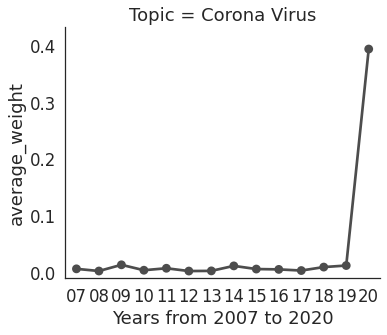

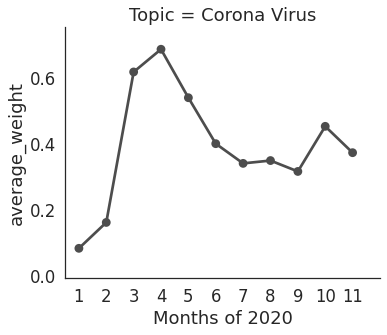

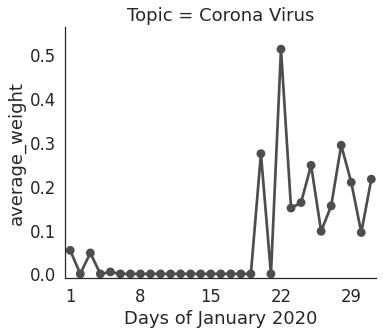

In [26]:
warnings.filterwarnings("ignore")

dfs = df_with_avg_weights
dfs = dfs.rename(columns={"topic_label":"Topic"})
# set range of all topics to plot all topics, here, just Corona-Virus is chosen
for i in range(12,13):
    sns.set(font_scale=1.5)
    sns.set_style("white")
    dfs = df_with_avg_weights[(df_with_avg_weights['topic'] == i)].reset_index()
    dfs = dfs.rename(columns={"topic_label":"Topic"})
    dfs.drop(columns=['Unnamed: 0'],inplace=True)
    # set year and month, which should be plotted
    dfs_days = dfs.loc[(dfs['year']==2020) & (dfs['month']==1)].reset_index().drop(columns='level_0')
    dfs_months = dfs.loc[(dfs['year']==2020)].reset_index().drop(columns='level_0')
    dfs_years = dfs
    
    #prepare plot
    topiic_labels = dfs['Topic'].unique()
    dfs_years = dfs_years.rename(columns={"year":"years"})
    dfs_days = dfs_days.rename(columns={"days":"Days of January 2020"})
    for row in range(len(dfs_years['years'])):
        dfs_years.at[row,'Years from 2007 to 2020'] = str(dfs_years.loc[row,'years'])[2:4]
    for row in range(len(dfs_months['months'])):
        if dfs_months.loc[row,'months'][1] == '/':
            dfs_months.at[row,'Months of 2020'] = str(dfs_months.loc[row,'months'])[:1]
        else:
            dfs_months.at[row,'Months of 2020'] = str(dfs_months.loc[row,'months'])[:2]
    for row in range(len(dfs_days['Days of January 2020'])):
        if dfs_days.loc[row,'Days of January 2020'][1] == '/':
            dfs_days.at[row,'Days of January 2020'] = str(dfs_days.loc[row,'Days of January 2020'])[:1]
        else:
            dfs_days.at[row,'Days of January 2020'] = str(dfs_days.loc[row,'Days of January 2020'])[:2]
    
    # year to year
    # use maximum average weights of the years
    years_max = dfs_years.groupby(['years'])['average_weight'].mean().max()
    g = sns.FacetGrid(dfs_years, col="Topic", col_wrap=3, height=5, ylim=(-0.01, years_max*1.1))
    g.map(sns.pointplot, "Years from 2007 to 2020", 'average_weight', ci=None,color='.3')
    g.set(xticks=dfs_years["Topic"].index[0:14])
    g.savefig("outputYears.png")
    
    # month to month
    # use maximum average weights of the month
    month_max = dfs_months.groupby(['months'])['average_weight'].mean().max()
    g = sns.FacetGrid(dfs_months, col="Topic", col_wrap=3, height=5, ylim=(-0.01, month_max*1.1))
    g.map(sns.pointplot, "Months of 2020", 'average_weight', ci=None,color='.3')
    g.set(xticks=dfs["Topic"].index[:12])
    g.savefig("outputMonth.png")

    
    # day to day
    # use maximum average weights of the days
    day_max = dfs_days.groupby(['Days of January 2020'])['average_weight'].mean().max()
    g = sns.FacetGrid(dfs_days, col="Topic", col_wrap=3, height=5, ylim=(-0.01, day_max*1.1))
    g.map(sns.pointplot, "Days of January 2020", 'average_weight', ci=None,color='.3')
    g.set(xticks=dfs["Topic"].index[::7][:5])
    g.savefig("outputDays.png")
